In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plot_format = {
    0  : ['mediumseagreen', '-'],
    1  : ['blue', ':'],
    2  : ['green', '-.'],
    3  : ['black', '--'],
    4  : ['hotpink', '-'],
    5  : ['orange', ':'],
    6  : ['brown', '-.'],
    7  : ['purple', '--'],
    8  : ['aquamarine', '-'],
    9  : ['red', ':'],
    10 : ['lawngreen', '-.'],
    11 : ['burlywood', '--'],
    12 : ['cadetblue', '-'],
    13 : ['darkgreen', ':'],
    14 : ['coral', '-.'],
    15 : ['cyan', '--'],
}

In [7]:
class DetermineFit():
    def __init__(self):
        self.directory = ''
        self.files = []

    def find_gaussian_fit(self, directory, row=0, column=0):
        self.row = row
        self.column = column
        files = [x for x in os.listdir(directory)]
        if files != self.files:
            self.files = [x for x in os.listdir(directory)]
            self.directory = directory
            self.static_trim()
        self.plot_static()

    def find_pixel(self, initial_threshold_values):
        all_rising_edges = np.zeros((324,324), dtype=int)
        cols = initial_threshold_values.shape[1]
        rows = initial_threshold_values.shape[2]
        for c in range(cols):
            for r in range(rows):
                rising_edge = np.where(np.diff(initial_threshold_values[:,c,r] > 50))[0]
                if len(rising_edge) != 0: 
                    all_rising_edges[c,r] = rising_edge[0]
                else:
                    all_rising_edges[c,r]  = 10000
        return all_rising_edges

    # Define the Gaussian function
    def gaussian(self, x, amplitude, mean, stddev):
        return amplitude * np.exp(-((x - mean) / stddev) ** 2)

    def static_trim(self):
        v_thresh = []
        initial_threshold_values = []
        for _, opf in enumerate(self.files):
            name = opf.split('_')
            v_thresh.append(int(name[0][1:]))
            data = np.loadtxt(f'{self.directory}/{opf}', delimiter=',', dtype=np.uint8, converters=float, comments='#')
            initial_threshold_values.append(data)
        v_thresh = np.array(v_thresh)
        initial_threshold_values = np.array(initial_threshold_values)
        # Create an array for storing the counts of x value
        counts = np.zeros((v_thresh.shape))
        rising_edge_indices = self.find_pixel(initial_threshold_values)
        # Get the values of each rising edge and the counts
        values, unique_counts = np.unique(rising_edge_indices,return_counts=True)
        values, unique_counts = values[:-1], unique_counts[:-1] # Remove invalid values
        # Set the counts for each x value, some values do not appear so we cant just use the unique results
        counts[values] = unique_counts

        # Fit the data to the Gaussian function
        popt, pcov = curve_fit(self.gaussian, v_thresh, counts, p0=[max(counts), np.mean(v_thresh), np.std(v_thresh)])

        # Extract the optimized parameters
        self.amplitude, self.mean, self.stddev = popt

        # Generate the fitted curve
        self.x_fit = np.linspace(min(v_thresh), max(v_thresh), 1000)
        self.y_fit = self.gaussian(self.x_fit, *popt)

        self.v_thresh = v_thresh
        self.initial_threshold_values = initial_threshold_values
        self.counts = counts

    def plot_static(self):
        fig, axs = plt.subplots(1, 2, figsize=(14, 7))
        axs[0].plot(self.v_thresh, self.initial_threshold_values[:,self.row,self.column], 'b+:')
        axs[0].set(xlabel='Voltage Threshold (mV)', ylabel='Digital Signal', title=f'Pixel : {self.row},{self.column}')
        axs[1].plot(self.v_thresh, self.counts,'b+:',label='Data')
        axs[1].plot(self.x_fit, self.y_fit, 'r', label=f'Mean : {self.mean:.2f} Std Dev : {self.stddev:.2f}', alpha=0.5)
        axs[1].plot(self.mean, self.amplitude, 'ro')
        axs[1].plot([self.mean - self.stddev, self.mean + self.stddev], [self.amplitude * 0.4, self.amplitude * 0.4], 'r:')
        axs[1].legend()
        axs[1].set(xlabel='Voltage Threshold (mV)', ylabel='Pixel Population', title='Mean Rising Edge Fit')
        plt.savefig(f'{self.directory}/Calibration.png')

determine_fit = DetermineFit()

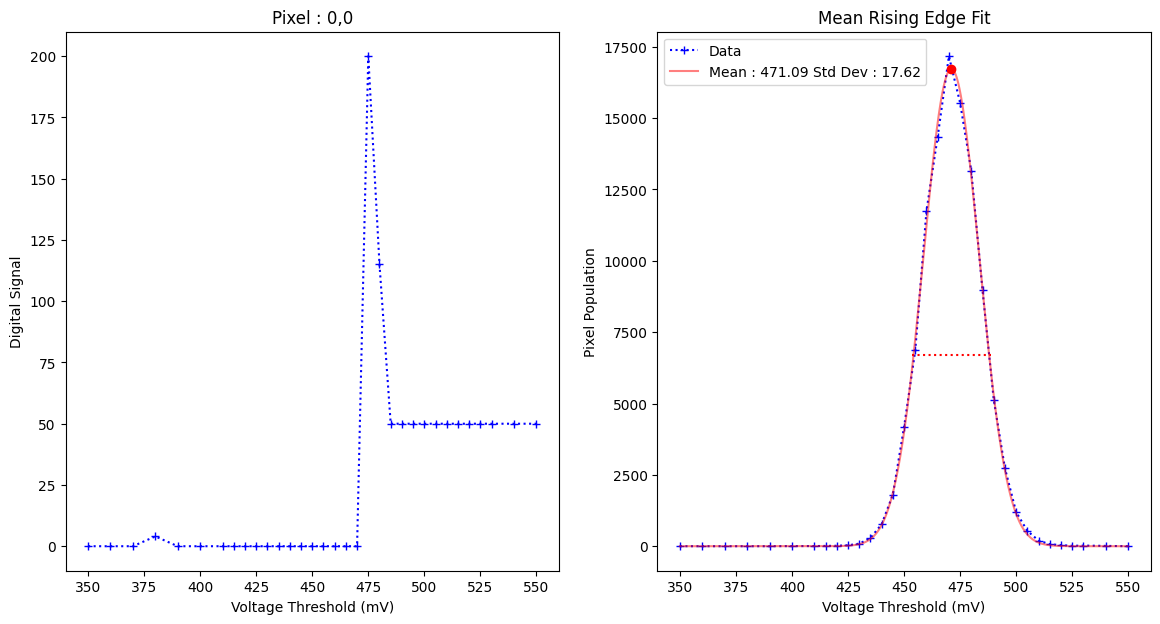

In [9]:
# Determine mean rising edge from a trim value of 15 for all pixels
directory = f'C:/Users/chem-chem1612/Documents/PIMMS-Calibration/25-07-24/15'
determine_fit.find_gaussian_fit(directory,row=0,column=0)

In [4]:
directory = 'Q:/Cameras/PImMS/Trim_Files/25-07-24'
mean = 471.09

files = [x for x in os.listdir(directory) if x.endswith('.csv')]

pixels = {}
for a in range(324):
    for b in range(324):
        pixels[f'{a},{b}'] = {x : 0 for x in range(0,15)}

for trim in range(0,15):
    trim_files = [x for x in files if f'T{trim}_' in x]
    if len(trim_files) == 0: continue
    data_stacked = []
    vthps = []
    for file in trim_files:
        vthp = file.split('_')[1][1:]
        vthps.append(int(vthp))
        filepath = f'{directory}/{file}'
        data = np.loadtxt(filepath, delimiter=',', dtype=np.uint8, converters=float, comments='#')
        data_stacked.append(data)
    data_stacked = np.array(data_stacked)
    for a in range(324):
        for b in range(324):
            rising_edge = np.where(np.diff(data_stacked[:,a,b] > 50))[0]
            if len(rising_edge) != 0: 
                pixels[f'{a},{b}'][trim] = vthps[rising_edge[0]]
            else:
                pixels[f'{a},{b}'][trim] = 10000

trim_values = np.zeros((324,324), dtype=int)
for a in range(324):
    for b in range(324):
        lowest = 99
        for trim in range(0,15):
            difference = abs(mean - pixels[f'{a},{b}'][trim])
            if difference < lowest:
                lowest = difference
                trim_values[a][b] = trim
np.savetxt(f"{directory}/Calibration.csv", trim_values, delimiter=",", fmt='%d')

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [ 1300  6867  1013  3522  5476 10435  8506 20291  1070  9788   665  5188
  3572 15778  2635  8870]


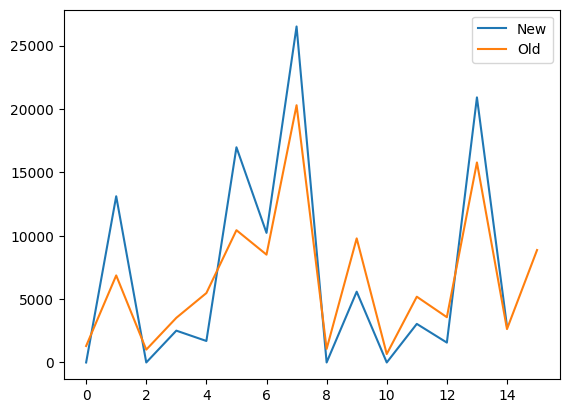

In [5]:
# Compare new calibration to old calibration
filepath = 'Q:/Cameras/PImMS/Trim_Files/25-07-24/Calibration.csv'
data = np.loadtxt(filepath, delimiter=',', dtype=np.uint8, converters=float, comments='#')
uniques, counts = np.unique(data, return_counts=True)
X = np.array([x for x in range(0,15)])
Y = np.zeros((15,))
Y[uniques] = counts
plt.plot(X, Y, label='New')
filepath = 'Q:/Cameras/PImMS/Trim_Files/12.csv'
data = np.loadtxt(filepath, delimiter=',', dtype=np.uint8, converters=float, comments='#')
uniques, counts = np.unique(data, return_counts=True)
print(uniques, counts)
plt.plot(uniques,counts, label='Old')
plt.legend()
